Notes:

Would it be smart to delete the dataframe used for plots after I create them? I don't plan to use them later so it just takes up storage space, all be it not much for this data. 

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from datetime import timedelta

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (8,6)

from tkinter import Tk     
from tkinter.filedialog import askopenfilename

# Add columns to easily work on analysis

In [2]:
music = pd.read_json("./Data - 2022/StreamingHistory0.json")
music = music.rename(columns = {"endTime": "ended", "artistName": "artist", "trackName": "track"})
print("Count of songs: ", len(music))
music.head(3)

Count of songs:  10127


,ended,artist,track,msPlayed
0,2021-06-28 22:34,Randy Rogers Band,In My Arms Instead,265300
1,2021-07-06 03:25,Daft Punk,"End of Line - From ""TRON: Legacy""/Score",119980
2,2021-07-09 15:04,Alabama,Mountain Music,218613


In [3]:
genres = pd.read_csv("./Data - Song Genres.csv")
music = pd.merge(music, genres, how="left", left_on=["artist", "track"], right_on=["artist", "track"])
music = music.replace(np.nan,'misc',regex=True)
music = music.rename(columns={"generic genre": "genre"})
music.head(3)

,ended,artist,track,msPlayed,genre
0,2021-06-28 22:34,Randy Rogers Band,In My Arms Instead,265300,country
1,2021-07-06 03:25,Daft Punk,"End of Line - From ""TRON: Legacy""/Score",119980,electro
2,2021-07-09 15:04,Alabama,Mountain Music,218613,country


In [4]:
music["minutesPlayed"] = music["msPlayed"].apply(lambda ms: ms/1000/60) # Convert to minutes, more readable


# Seperating out the time into multiple columns
date_data = music["ended"].apply(lambda date: (datetime.strptime(date, "%Y-%m-%d %H:%M") - timedelta(hours=5)).timetuple())

music["year"] = [val.tm_year for val in date_data]
music["month"] = [val.tm_mon for val in date_data]
music["day of week"] = [val.tm_wday for val in date_data]
music["day of month"] = [val.tm_mday for val in date_data]
music["day of year"] = [val.tm_yday for val in date_data]
music["hour"] = [val.tm_hour for val in date_data]
music["minute"] = [val.tm_min for val in date_data]

### Since creating this, I have discovered how to get the information I need without having to split the date into multiple columns

In [5]:
music

,ended,artist,track,msPlayed,genre,minutesPlayed,year,month,day of week,day of month,day of year,hour,minute
0,2021-06-28 22:34,Randy Rogers Band,In My Arms Instead,265300,country,4.421667,2021,6,0,28,179,17,34
1,2021-07-06 03:25,Daft Punk,"End of Line - From ""TRON: Legacy""/Score",119980,electro,1.999667,2021,7,0,5,186,22,25
2,2021-07-09 15:04,Alabama,Mountain Music,218613,country,3.643550,2021,7,4,9,190,10,4
3,2021-07-09 15:04,C.W. McCall,Convoy,7041,country,0.117350,2021,7,4,9,190,10,4
4,2021-07-09 15:04,Willie Nelson,On the Road Again - Live,1813,country,0.030217,2021,7,4,9,190,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,2022-07-09 23:08,Wolfmother,Victorious,264986,rock,4.416433,2022,7,5,9,190,18,8
10123,2022-07-09 23:11,Wolfmother,Baroness,195373,rock,3.256217,2022,7,5,9,190,18,11
10124,2022-07-09 23:15,Wolfmother,Pretty Peggy,229000,rock,3.816667,2022,7,5,9,190,18,15
10125,2022-07-09 23:18,Wolfmother,Happy Face,210973,rock,3.516217,2022,7,5,9,190,18,18


# Analysing aspects of the data

### How much music do I listen to in a year

In [6]:
totalmin = np.sum(music["minutesPlayed"])
print("Minutes listened to: %.2f" % totalmin)
print("Days listened to: %.2f" % (totalmin/60/24))
print("Percent of the year: %.2f" % (totalmin/60/24/365*100) +"%") # Interesting but not meaningful

print("Average minutes per day listened: %.2f" % (totalmin/365)) # Most meaningful thing here

Minutes listened to: 24391.89
Days listened to: 16.94
Percent of the year: 4.64%
Average minutes per day listened: 66.83


### General info

In [7]:
print("Time ranges from ", min(music["ended"]), " to ", max(music["ended"]))

Time ranges from  2021-06-28 22:34  to  2022-07-09 23:22


### What artist do I listen to the most?
Find the top 10 or so and graph distribution (histogram) and a bar chart

For the bar chart, if I had genres I would use that for coloring each bar

In [8]:
artist_time = music[["artist", "minutesPlayed"]].groupby("artist").sum().sort_values("minutesPlayed", ascending=False)
print(len(artist_time))
artist_time.head(3)

747


,minutesPlayed
artist,
The High Kings,2107.854350
AJR,1921.714350
Daft Punk,1799.903683


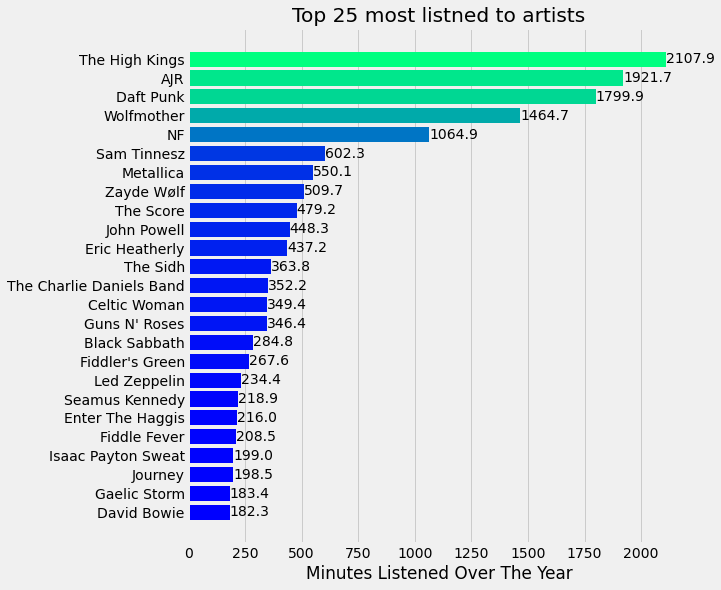

In [9]:
# Change amt to incrase the amount of songs displayed
amt = 25


fig, ax = plt.subplots(figsize=(8,amt/3 + .5))

x = np.arange(amt)
y = artist_time["minutesPlayed"][0:amt]

my_cmap = plt.get_cmap("winter")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y)) # / 2 to only take the bottom half of the colormap
p1 = ax.barh(x, y, color=my_cmap(rescale(y)))

ax.set_xlabel("Minutes Listened Over The Year")
ax.set_title("Top " + str(amt) + " most listned to artists")
plt.yticks(x, labels=artist_time.index[0:amt])
ax.invert_yaxis()


ax.bar_label(p1, labels=["%.1f" % e for e in y])
ax.yaxis.grid(False)

norm = plt.Normalize(y.min(), y.max())
#fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)
# Since each bar shows it's value as a number, no reason to add a colorbar
plt.show()

### What time of day do I listen to most
Group by hours and minutes

In [10]:
minute_bins = np.arange(0,61,15)
hour_bins = np.arange(0,25,1)
listened_per_day = music[["hour", "minute", "minutesPlayed"]].groupby([pd.cut(music["hour"], hour_bins, right=False), pd.cut(music["minute"], minute_bins)]).sum()
listened_per_day = listened_per_day.drop("minute", axis=1)

# Copy the first value to the end to make the plot flow
listened_per_day = pd.concat([listened_per_day, listened_per_day.iloc[[0]]])


hr_labels = ["12 am"]
for t in np.arange(1,12):
    hr_labels = np.append(hr_labels, str(t)+ " am")
hr_labels = np.append(hr_labels, "12 pm")
for t in np.arange(1,12):
    hr_labels = np.append(hr_labels, str(t)+ " pm")
hr_labels = np.append(hr_labels, "12 am")

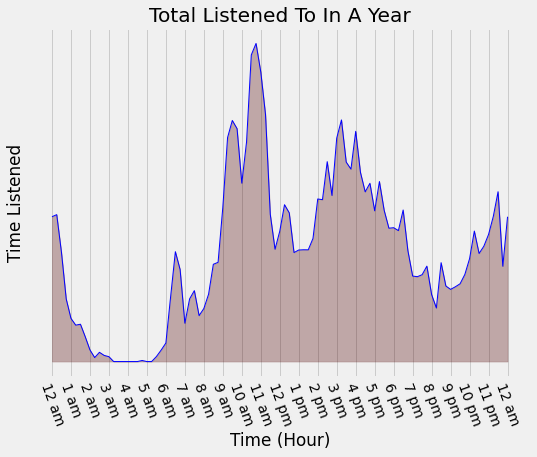

In [11]:
fig, ax = plt.subplots(figsize = (8,6))

x = np.arange(len(listened_per_day))
y = listened_per_day["minutesPlayed"]
ax.plot(x, y, linewidth=1, color="blue")
plt.fill_between(x, 0, y, alpha=0.3, color="#500000") # Color, aggie maroon

plt.xticks(np.arange(0,len(listened_per_day)+1, 4), labels=hr_labels, rotation = -70)
ax.set_title("Total Listened To In A Year")
ax.set_xlabel("Time (Hour)")

ax.set_ylabel("Time Listened")
ax.yaxis.grid(False)
plt.yticks([])

plt.show()

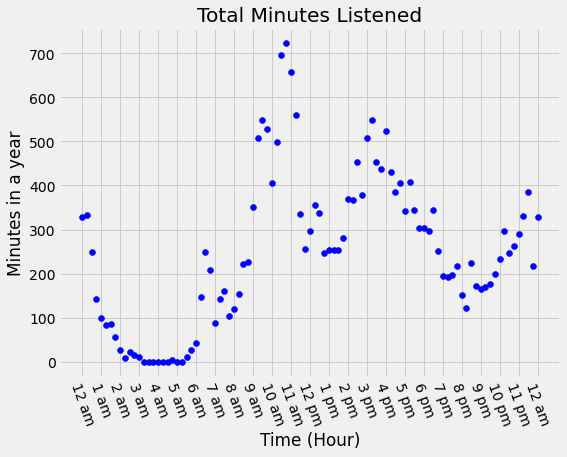

In [12]:
fig, ax = plt.subplots(figsize = (8,6))

x = np.arange(len(listened_per_day))
y = listened_per_day["minutesPlayed"]
ax.scatter(x, y, color="blue")

#ax.set_xticks(np.arange(0,len(listened_per_day), 4), labels=hr_labels, rotation = -70)
plt.xticks(np.arange(0,len(listened_per_day), 4), labels=hr_labels, rotation = -70)
ax.set_title("Total Minutes Listened")
ax.set_xlabel("Time (Hour)")
ax.set_ylabel("Minutes in a year")

plt.show()

### What time of year do I listen to the most
Similar to above, I will make a line plot but this time x axis will be the month of the year

In [13]:
monthly_listened = music[["minutesPlayed", "month"]].groupby("month").sum()
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

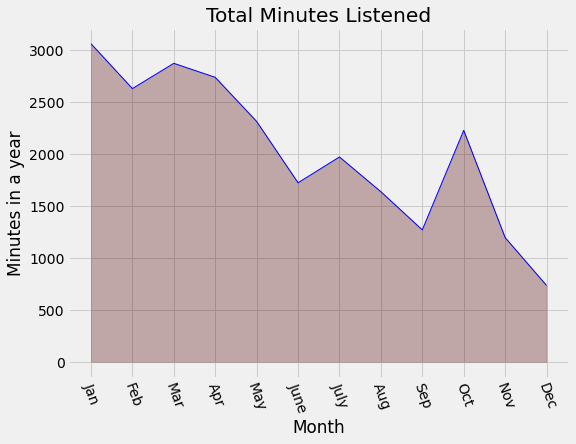

In [14]:
fig, ax = plt.subplots(figsize = (8,6))

x = np.arange(len(monthly_listened))
y = monthly_listened["minutesPlayed"]

ax.plot(x, y, linewidth=1, color="blue")
plt.fill_between(x, 0, y, alpha=0.3, color="#500000") # Color, aggie maroon

#ax.set_xticks(x, labels=month_labels, rotation = -70)
plt.xticks(x, labels=month_labels, rotation = -70)

ax.set_title("Total Minutes Listened")
ax.set_xlabel("Month")
ax.set_ylabel("Minutes in a year")

plt.show()

# Does the time of day that I listen to music depend on the month?
I will maked a stacked bar chart, each column would be a given month. Inside each column I will divide it into intervals of 15 minutes, as before. Each box will have a equal height so I will use colormap to denote the amount I listened to.

Since I don't care about which months I listen to more, I will normalize each month so that the time I listen to will be much more noticable.

In [15]:
minute_bins = np.arange(0,61,15)
hour_bins = np.arange(0,25,1)
listened_per_month = music[["month", "hour", "minute", "minutesPlayed"]].groupby([music["month"], pd.cut(music["hour"], hour_bins, right=False), pd.cut(music["minute"], minute_bins)]).sum()
listened_per_month = listened_per_month.drop(["minute", "month", "hour"], axis=1)
#listened_per_month

In [16]:
lpm_scaled = pd.DataFrame(dtype=np.float64)
for month in np.arange(1,13,1):
    highest = max(listened_per_month.loc[ pd.IndexSlice[month, :, :] ]["minutesPlayed"])
    lowest = min(listened_per_month.loc[ pd.IndexSlice[month, :, :] ]["minutesPlayed"])
    
    per_month = listened_per_month.loc[ pd.IndexSlice[month, :, :] ].apply(lambda y: (y - lowest)/(highest-lowest))
    per_month = pd.concat([per_month], keys=[month], names=["month"])
    lpm_scaled = pd.concat([lpm_scaled, per_month])
    
#lpm_scaled

C:\Users\ryane\AppData\Local\Temp\ipykernel_10104\2389330152.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)


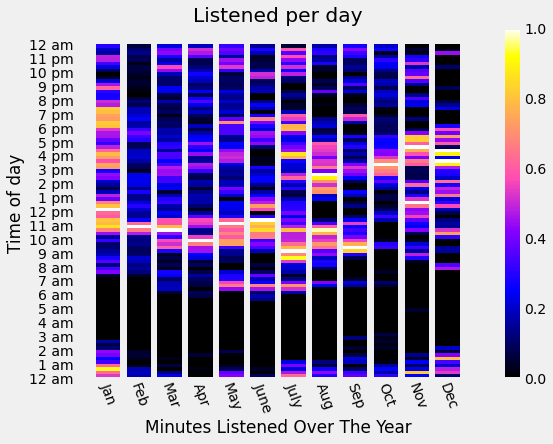

In [17]:
# Same code as previous version but using lpm_scaled instead of listened_per_month

fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(12)
y = 0


#my_cmap = plt.get_cmap("BuPu")
my_cmap = plt.get_cmap("gnuplot2")

for hour in np.arange(24):
    for minute in [15,30,45,60]:
        partition = lpm_scaled.loc[ pd.IndexSlice[:, hour, minute] ]["minutesPlayed"] # Particular hour and minute for all months
        ax.bar(x, 1, color=my_cmap(partition), bottom = y)
        y += 1
    

ax.set_xlabel("Minutes Listened Over The Year")
plt.xticks(x, labels=month_labels, rotation = -70)


ax.set_ylabel("Time of day")
plt.yticks(np.arange(0,len(lpm_scaled)/12+1, 4), labels=hr_labels)

ax.set_title("Listened per day")


ax.grid(False)

norm = plt.Normalize(np.min(lpm_scaled["minutesPlayed"]), np.max(lpm_scaled["minutesPlayed"]))
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)

plt.show()

# What days of the week do I listen to music?
Idea: Same thing as above except the x-axis will be weekdays. Do not scale the values to be normalized per weekday

In [18]:
# Past Code
minute_bins = np.arange(0,61,15)
hour_bins = np.arange(0,25,1)
listened_per_week = music[["day of week", "hour", "minute", "minutesPlayed"]].groupby([music["day of week"], pd.cut(music["hour"], hour_bins, right=False), pd.cut(music["minute"], minute_bins)]).sum()
listened_per_week = listened_per_week.drop(["minute", "hour", "day of week"], axis=1)
#listened_per_week
# Day of week: 0 is Monday and 6 is Sunday

In [19]:
week_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

C:\Users\ryane\AppData\Local\Temp\ipykernel_10104\249166369.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)


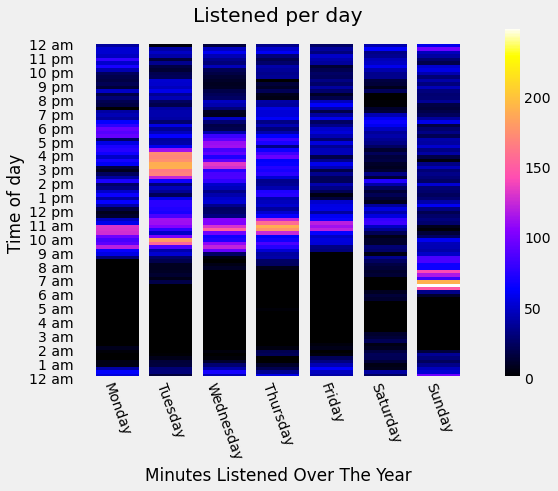

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(7)
y = 0

#my_cmap = plt.get_cmap("BuPu")
my_cmap = plt.get_cmap("gnuplot2")

maximum = np.max(listened_per_week["minutesPlayed"])
minimum = np.min(listened_per_week["minutesPlayed"])
rescale2 = lambda y: (y - minimum) / (maximum - minimum)

for hour in np.arange(24):
    for minute in [15,30,45,60]:
        partition = listened_per_week.loc[ pd.IndexSlice[:, hour, minute] ] # Particular hour and minute for all week days
        ax.bar(x, 1, color=my_cmap(rescale2(partition)), bottom = y)
        y += 1
    

ax.set_xlabel("Minutes Listened Over The Year")
#ax.set_xticks(x, labels=month_labels, rotation = -70)
plt.xticks(x, labels=week_labels, rotation = -70)


ax.set_ylabel("Time of day")
#ax.set_yticks(np.arange(0,len(listened_per_week)/12+1, 4), labels=hr_labels)
plt.yticks(np.arange(0,97, 4), labels=hr_labels)

ax.set_title("Listened per day")


#ax.bar_label(p1, labels=["%.1f" % e for e in y])
ax.grid(False)

norm = plt.Normalize(minimum, maximum)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)

plt.show()

Now just a simple bar plot with heights of how much was listened to in a day

In [21]:
amt_wkday = music[["minutesPlayed", "day of week"]].groupby("day of week").sum()["minutesPlayed"]
amt_wkday

day of week
0    3437.197900
1    4578.040667
2    3788.439767
3    3792.951983
4    2786.773283
5    2267.290900
6    3741.198567
Name: minutesPlayed, dtype: float64

C:\Users\ryane\AppData\Local\Temp\ipykernel_10104\2753123628.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)


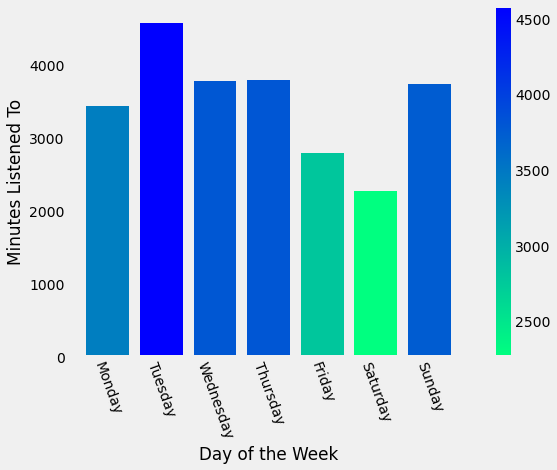

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(7)

my_cmap = plt.get_cmap("winter_r")
#my_cmap = plt.get_cmap("gnuplot2")

maximum = np.max(amt_wkday)
minimum = np.min(amt_wkday)
rescale2 = lambda y: (y - minimum) / (maximum - minimum)

ax.bar(x, amt_wkday, color=my_cmap(rescale2(amt_wkday)))

ax.set_xlabel("Day of the Week")
plt.xticks(x, labels=week_labels, rotation = -70)

ax.set_ylabel("Minutes Listened To")
ax.grid(False)

norm = plt.Normalize(minimum, maximum)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=my_cmap), ax=ax)

plt.show()

# Does the artist that I listen to depend on the month?
Plan: line plot diagram (x=month, y=minutesPlayed) with a line per top artist

Find the best artist to use by looking at each month and picking the 2 most listened to artists. Then each line will be a unique artist. Most of 24 artists but I expect it will be significantly lower

In [23]:
# Finding the best artists
artist_per_month = music[["minutesPlayed", "artist","month"]].groupby(["month","artist"]).sum()

top_artist = set()
for month in np.arange(12):
    for name in artist_per_month.loc[ pd.IndexSlice[month+1,:]].sort_values("minutesPlayed", ascending=False).index[0:1]:
        top_artist.add(name)
top_artist

{'AJR', 'Daft Punk', 'John Powell', 'NF', 'The High Kings', 'Wolfmother'}

In [24]:
filtered = music[music["artist"].isin(top_artist)][["minutesPlayed", "artist", "month"]]
filtered # Need to add in the artist-months that do not have data

,minutesPlayed,artist,month
1,1.999667,Daft Punk,7
19,3.432533,Wolfmother,7
20,3.758217,Wolfmother,7
21,4.073333,Wolfmother,7
22,4.674433,Wolfmother,7
...,...,...,...
10122,4.416433,Wolfmother,7
10123,3.256217,Wolfmother,7
10124,3.816667,Wolfmother,7
10125,3.516217,Wolfmother,7


In [25]:
to_add = pd.DataFrame([], columns=['minutesPlayed', 'artist', "month"])

for band in top_artist:
    diff = set(np.arange(1,13)) - set(filtered.groupby(["artist", "month"]).sum().loc[pd.IndexSlice[band, :]].index)
    for i in diff:
        to_add = pd.concat([to_add, pd.DataFrame([[0, band, i]], columns=['minutesPlayed', 'artist', "month"])])

to_add

,minutesPlayed,artist,month
0,0,John Powell,1
0,0,John Powell,2
0,0,John Powell,3
0,0,John Powell,5
0,0,John Powell,8
0,0,John Powell,9
0,0,John Powell,10
0,0,John Powell,11
0,0,John Powell,12
0,0,The High Kings,8


In [26]:
organized = pd.concat([filtered, to_add]).groupby(["artist", "month"]).sum()
organized

minutesPlayed
artist     month               
AJR        1         116.943450
           2          16.249333
           3          52.902283
           4          97.518283
           5         997.562417
...                         ...
Wolfmother 8         114.094433
           9          75.187483
           10        215.367417
           11        276.571533
           12         25.705283

[72 rows x 1 columns]

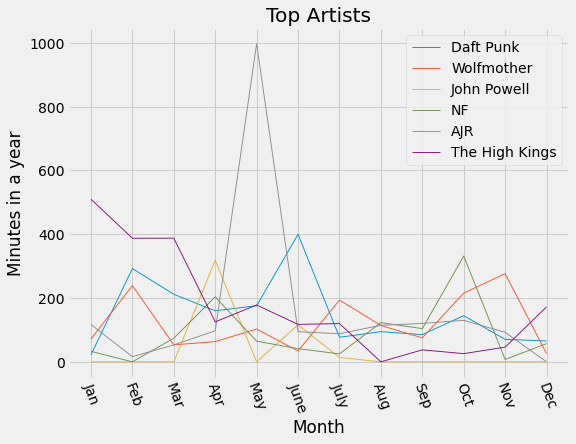

In [27]:
# Now we can use the 12 data points per each artist to make a multi-lined graph
fig, ax = plt.subplots(figsize = (8,6))

#remove = ["John Powell", "Daft Punk"]
remove = []
num_bands = len(top_artist - set(remove))
x = np.arange(12)

for band in top_artist:
    if band not in remove:
        y = organized.loc[ pd.IndexSlice[band,:]]["minutesPlayed"]
        ax.plot(x, y, linewidth=0.75+1/num_bands,label=band) # Linewidth gets thinner the more lines there are

plt.xticks(x, labels=month_labels, rotation = -70)

ax.set_title("Top Artists")
ax.set_xlabel("Month")
ax.set_ylabel("Minutes in a year")

ax.legend(loc='upper right')

plt.show()

# MatPlotLib colormaps
Used as a reference to pick out which colormaps I would like to use|

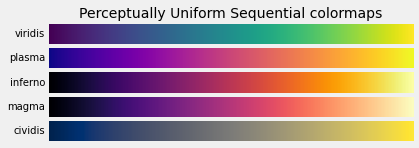

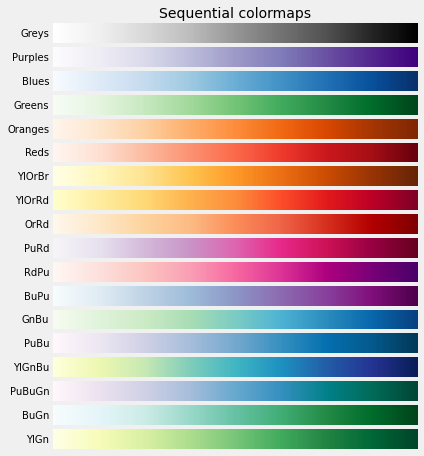

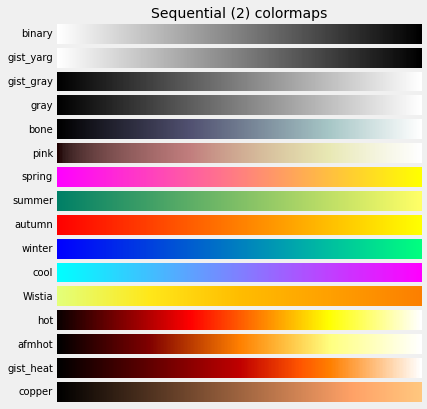

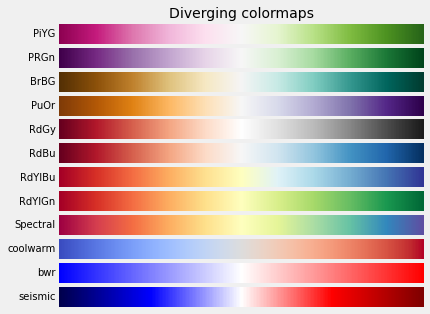

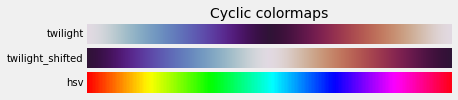

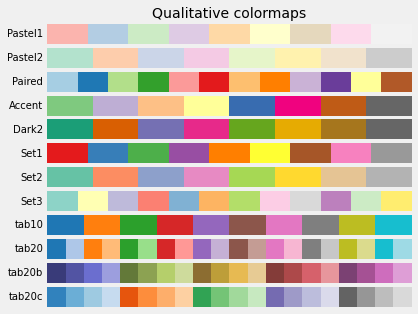

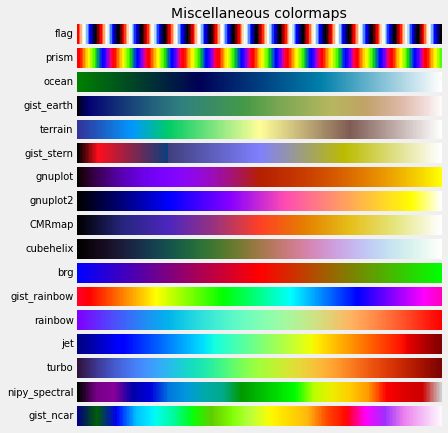

In [28]:
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]


gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    # Their equation, commented out, is made to keep the bar plots the same size no matter how many bars are made
    #figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.3
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps:
    plot_color_gradients(cmap_category, cmap_list)

plt.show()